<a href="https://colab.research.google.com/github/Fatima8024/NLP/blob/main/Sentiment_Analysis_using_Text2vec_with_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tensorflow scikit-learn pandas numpy


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
#import pandas as pd
# Load the dataset
df = pd.read_csv('COVID Fake News Data.csv')  # Replace with your file name

# Display the first few rows
df.head()


,headlines,outcome
0,A post claims compulsory vacination violates t...,0
1,A photo claims that this person is a doctor wh...,0
2,Post about a video claims that it is a protest...,0
3,All deaths by respiratory failure and pneumoni...,0
4,The dean of the College of Biologists of Euska...,0


In [ ]:
# check class distribution
df['outcome'].value_counts(normalize = True)

,proportion
outcome,
0,0.953534
1,0.046466


In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['headlines'], df['outcome'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['outcome'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)



In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<Axes: >

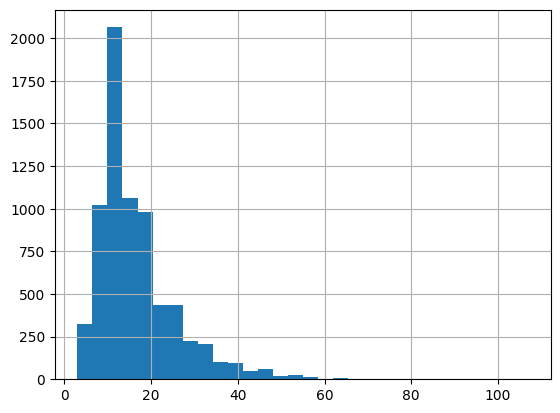

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = None,
    padding='max_length',
    #pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = None,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = None,
    padding='max_length',
    truncation=True
)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW
import torch.optim as optim

# define the optimizer
optimizer = optim.AdamW(model.parameters(),lr = 1e-5)

#The compute_class_weight function from the sklearn.utils.class_weight module is used to compute the class weights with multiple parameters for the training labels.

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print('Class Weights:',class_weights)

Class Weights: [ 0.52438308 10.75301205]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # Record the starting time before evaluation
    t0 = time.time()

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,} Elapsed: {}'.format(step, len(val_dataloader), elapsed))
          #  print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 10

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.575
Validation Loss: 0.569

 Epoch 2 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.568
Validation Loss: 0.554

 Epoch 3 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.546
Validation Loss: 0.551

 Epoch 4 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.544
Validation Loss: 0.534

 Epoch 5 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.530
Validation Loss: 0.518

 Epoch 6 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   20

In [ ]:
#load weights of best modelpath = 'saved_weights.pt'model.load_state_dict(torch.load(path))

# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

In [ ]:
# get predictions for test data in batches
batch_size = 32  # Adjust as needed
preds_list = []

# get predictions for test data
with torch.no_grad():
  for i in range(0, test_seq.shape[0], batch_size):
        batch_seq = test_seq[i:i + batch_size].to(device)
        batch_mask = test_mask[i:i + batch_size].to(device)
        preds = model(batch_seq, batch_mask)
        preds_list.extend(preds.detach().cpu().numpy())

preds = np.array(preds_list)

# get predictions for test data
# model's performance
preds = np.argmax(preds, axis = 1)

# Convert test_y to a NumPy array  <--- This is the added line
test_y_np = test_y.cpu().numpy()  # Move to CPU and convert to NumPy

print(classification_report(test_y, preds))

# Print the predictions
print("Predictions:")
for i, prediction in enumerate(preds):
    print(f"Sample {i}: {prediction}")


    #preds = model(test_seq.to(device), test_mask.to(device))
    #preds = preds.detach().cpu().numpy()


# model's performance
#preds = np.argmax(preds, axis = 1)
#print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1460
           1       0.28      0.66      0.39        71

    accuracy                           0.90      1531
   macro avg       0.63      0.79      0.67      1531
weighted avg       0.95      0.90      0.92      1531

Predictions:
Sample 0: 0
Sample 1: 0
Sample 2: 0
Sample 3: 0
Sample 4: 0
Sample 5: 0
Sample 6: 0
Sample 7: 0
Sample 8: 0
Sample 9: 0
Sample 10: 0
Sample 11: 0
Sample 12: 0
Sample 13: 1
Sample 14: 0
Sample 15: 0
Sample 16: 0
Sample 17: 0
Sample 18: 0
Sample 19: 0
Sample 20: 0
Sample 21: 0
Sample 22: 0
Sample 23: 0
Sample 24: 0
Sample 25: 0
Sample 26: 0
Sample 27: 0
Sample 28: 0
Sample 29: 0
Sample 30: 0
Sample 31: 0
Sample 32: 0
Sample 33: 0
Sample 34: 0
Sample 35: 1
Sample 36: 0
Sample 37: 0
Sample 38: 0
Sample 39: 0
Sample 40: 1
Sample 41: 0
Sample 42: 0
Sample 43: 0
Sample 44: 1
Sample 45: 0
Sample 46: 0
Sample 47: 0
Sample 48: 0
Sample 49: 0
Sample 50: 0
Sample 

now for RNN using Chatgpt 4o

In [ ]:
#Step 1: Update the Architecture for RNN

class BERT_RNN(nn.Module):
    def __init__(self, bert):
        super(BERT_RNN, self).__init__()

        self.bert = bert  # Pre-trained BERT model
        self.rnn = nn.RNN(input_size=768, hidden_size=128, batch_first=True)  # Add RNN layer
        self.fc = nn.Linear(128, 2)  # Fully connected output layer
        self.softmax = nn.LogSoftmax(dim=1)  # Output probabilities

    def forward(self, sent_id, mask):
        with torch.no_grad():  # Freeze BERT parameters
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        rnn_out, _ = self.rnn(cls_hs.unsqueeze(1))  # Pass embeddings through RNN
        rnn_out = rnn_out[:, -1, :]  # Take the last output of the RNN
        logits = self.fc(rnn_out)  # Fully connected layer
        probs = self.softmax(logits)  # Softmax for probabilities
        return probs

# Create an instance of the model
rnn_model = BERT_RNN(bert)
rnn_model = rnn_model.to(device)  # Move to GPU if available


In [ ]:
#Step 2: Define Loss Function and Optimizer

# Reuse the existing optimizer and loss function
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=1e-5)
cross_entropy = nn.NLLLoss(weight=weights)


In [ ]:
#Step 3: Training Loop

def train_rnn():
    rnn_model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        optimizer.zero_grad()  # Clear gradients
        preds = rnn_model(sent_id, mask)  # Forward pass
        loss = cross_entropy(preds, labels)  # Compute loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 1.0)  # Clip gradients
        optimizer.step()  # Update parameters

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


In [ ]:
#Code for Evaluation:


def evaluate_rnn():
    rnn_model.eval()
    total_loss = 0
    all_preds = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = [r.to(device) for r in batch]
            sent_id, mask, labels = batch
            preds = rnn_model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds = preds.detach().cpu().numpy()
            all_preds.extend(preds)

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss, np.array(all_preds)


In [ ]:
#Step 4: Training and Validation

best_valid_loss = float('inf')
epochs = 10

for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')
    train_loss = train_rnn()
    valid_loss, _ = evaluate_rnn()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn_model.state_dict(), 'best_rnn_model.pt')

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.669
Validation Loss: 0.665

 Epoch 2 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.658
Validation Loss: 0.651

 Epoch 3 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.650
Validation Loss: 0.639

 Epoch 4 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.631
Validation Loss: 0.632

 Epoch 5 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.618
Validation Loss: 0.615

 Epoch 6 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.609
Validation Loss: 0.604

 Epoch 7 / 10
 

In [ ]:
#Step 5: Testing the RNN

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


rnn_model.load_state_dict(torch.load('best_rnn_model.pt', map_location=device, weights_only=True))
rnn_model.eval()

all_preds = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        preds = rnn_model(sent_id, mask)
        preds = preds.detach().cpu().numpy()
        all_preds.extend(preds)

# Convert predictions to class labels
final_preds = np.argmax(all_preds, axis=1)

# Evaluate model performance
print(classification_report(test_y, final_preds))


              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1460
           1       0.25      0.42      0.32        71

    accuracy                           0.92      1531
   macro avg       0.61      0.68      0.64      1531
weighted avg       0.94      0.92      0.93      1531



Now applying LSTM

In [ ]:
class BERT_LSTM(nn.Module):
    def __init__(self, bert):
        super(BERT_LSTM, self).__init__()
        self.bert = bert  # Pre-trained BERT model
        self.lstm = nn.LSTM(input_size=768, hidden_size=128, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(128, 2)  # Fully connected output layer
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax for output probabilities

    def forward(self, sent_id, mask):
        with torch.no_grad():  # Freeze BERT parameters
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        lstm_out, _ = self.lstm(cls_hs.unsqueeze(1))  # Pass embeddings through LSTM
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state
        logits = self.fc(lstm_out)
        probs = self.softmax(logits)
        return probs

# Initialize the model
lstm_model = BERT_LSTM(bert)
lstm_model = lstm_model.to(device)  # Move to GPU if available


In [ ]:
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=1e-5)
cross_entropy = nn.NLLLoss(weight=weights)


In [ ]:
def train_lstm():
    lstm_model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        optimizer.zero_grad()  # Clear gradients
        preds = lstm_model(sent_id, mask)  # Forward pass
        loss = cross_entropy(preds, labels)  # Compute loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)  # Clip gradients
        optimizer.step()  # Update parameters

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


In [ ]:
def evaluate_lstm():
    lstm_model.eval()
    total_loss = 0
    all_preds = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = [r.to(device) for r in batch]
            sent_id, mask, labels = batch
            preds = lstm_model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds = preds.detach().cpu().numpy()
            all_preds.extend(preds)

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss, np.array(all_preds)


In [ ]:
best_valid_loss = float('inf')

for epoch in range(10):  # Adjust epochs as needed
    print(f'\n Epoch {epoch + 1} / 10')
    train_loss = train_lstm()
    valid_loss, _ = evaluate_lstm()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pt')

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.669
Validation Loss: 0.670

 Epoch 2 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.660
Validation Loss: 0.660

 Epoch 3 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.648
Validation Loss: 0.651

 Epoch 4 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.639
Validation Loss: 0.639

 Epoch 5 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.633
Validation Loss: 0.628

 Epoch 6 / 10
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Training Loss: 0.617
Validation Loss: 0.620

 Epoch 7 / 10
 

In [ ]:
lstm_model.load_state_dict(torch.load('best_lstm_model.pt'))
lstm_model.eval()

all_preds = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        preds = lstm_model(sent_id, mask)
        preds = preds.detach().cpu().numpy()
        all_preds.extend(preds)

final_preds = np.argmax(all_preds, axis=1)

# Evaluate model performance
print(classification_report(test_y, final_preds))


<ipython-input-69-5ab05b82a2c6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load('best_lstm_model.pt'))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1460
           1       0.25      0.46      0.33        71

    accuracy                           0.91      1531
   macro avg       0.61      0.70      0.64      1531
weighted avg       0.94      0.91      0.92      1531



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def compute_metrics_from_report(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    # Disable gradient computation
    with torch.no_grad():
        for batch in test_dataloader:
            batch = [r.to(device) for r in batch]
            #seq,labels = batch
            sent_id,mask,labels = batch

            # Model predictions
            preds = model(sent_id,mask)

            # Compute loss
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            # Extract predictions and true labels
            preds = preds.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            all_preds.extend(np.argmax(preds, axis=1))
            all_labels.extend(labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    avg_loss = total_loss / len(test_dataloader)

    return accuracy, precision, recall, f1, avg_loss

# Extract metrics for Text2Vec + RNN
rnn_metrics = compute_metrics_from_report(rnn_model, test_dataloader)
print("Text2Vec + RNN Metrics:")
print(f"Accuracy: {rnn_metrics[0]:.4f}")
print(f"Precision: {rnn_metrics[1]:.4f}")
print(f"Recall: {rnn_metrics[2]:.4f}")
print(f"F1-Score: {rnn_metrics[3]:.4f}")
print(f"Loss Value: {rnn_metrics[4]:.4f}")

# Extract metrics for Text2Vec + LSTM
lstm_metrics = compute_metrics_from_report(lstm_model, test_dataloader)
print("\nText2Vec + LSTM Metrics:")
print(f"Accuracy: {lstm_metrics[0]:.4f}")
print(f"Precision: {lstm_metrics[1]:.4f}")
print(f"Recall: {lstm_metrics[2]:.4f}")
print(f"F1-Score: {lstm_metrics[3]:.4f}")
print(f"Loss Value: {lstm_metrics[4]:.4f}")

# Create a table to compare results
import pandas as pd

comparison_table = pd.DataFrame({
    "Metric": ["Test Accuracy", "Precision", "Recall", "F1-Score", "Loss Value"],
    "Text2Vec + RNN":rnn_metrics,
    "Text2Vec + LSTM":lstm_metrics
})

# Display the table
print("\nComparison Table:")
print(comparison_table)


Text2Vec + RNN Metrics:
Accuracy: 0.9157
Precision: 0.9377
Recall: 0.9157
F1-Score: 0.9255
Loss Value: 0.5497

Text2Vec + LSTM Metrics:
Accuracy: 0.9105
Precision: 0.9393
Recall: 0.9105
F1-Score: 0.9230
Loss Value: 0.5573

Comparison Table:
          Metric  Text2Vec + RNN  Text2Vec + LSTM
0  Test Accuracy        0.915741         0.910516
1      Precision        0.937745         0.939316
2         Recall        0.915741         0.910516
3       F1-Score        0.925529         0.923006
4     Loss Value        0.549704         0.557311
